# **1. 데이터 차원**
- 데이터 자체는 충분함
- 불균형 데이터 -> Data Augmentation
- 데이터 범위(scale) 조정: 정규화/규제화/표준화

# **2. 알고리즘 차원**
- 학습률(learning rate)
    - 초기 설정: 1e-2
- 활성화 함수/손실함수
    - 활성화 함수: softmax
    - 손실 함수: CrossEntropyLoss
- 배치/ Epoch
    - batch_size: 128
    - Epoch: 100

# **3. 하드웨어 차원**
- gpu 활용

In [1]:
### 필요한 라이브러리 준비

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import copy
import argparse

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from ipywidgets import interact
from module.pytorchtools import EarlyStopping # 사용자 정의 모듈
                                              # 외부 py파일을 모듈로 import하여 EarlyStopping 함수 사용

In [2]:
### gpu 장치 확인
print(torch.__version__) 
print(torch.cuda.get_device_name(0))

1.12.1+cu116
NVIDIA GeForce GTX 1660 SUPER


### **DataLoader**

In [3]:
train_data_dir = './DataSet/archive/train/'
train_data_df = pd.read_csv(os.path.join(train_data_dir,'train.csv'))

# 분류에 사용할 class 정의(7개의 감정들)
feelings_list = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [4]:
IMAGE_SIZE = 48

### 이미지 파일 경로를 리스트 형태로 저장하기 위한 함수
def list_image_file(data_dir,sub_dir):
    image_files = []
    
    images_dir = os.path.join(data_dir,sub_dir)
    for file_path in os.listdir(images_dir):
        image_files.append(os.path.join(sub_dir,file_path))
    return image_files

In [5]:
### 학습 데이터셋 클래스
class Feeling_dataset(Dataset):
    ### 생성자
    def __init__(self,data_dir,transform = None):
        self.data_dir = data_dir # 데이터가 저장된 상위 directory
        angry_imgs = list_image_file(data_dir,'angry')
        disgust_imgs = list_image_file(data_dir,'disgust')
        fear_imgs = list_image_file(data_dir,'fear')
        happy_imgs = list_image_file(data_dir,'happy')
        neutral_imgs = list_image_file(data_dir,'neutral')
        sad_imgs = list_image_file(data_dir,'sad')
        surprise_imgs = list_image_file(data_dir,'surprise')
        
        # 모든 사진들의 경로를 하나의 리스트에 저장
        self.files_path = angry_imgs + disgust_imgs + fear_imgs + happy_imgs + neutral_imgs + sad_imgs + surprise_imgs
        self.transform = transform
    
    ### 데이터 개수 확인
    def __len__(self):
        return len(self.files_path) # 전체 데이터 개수
    
    ### getitem
    def __getitem__(self,index):
        # image(feature data)
        image_file = os.path.join(self.data_dir,self.files_path[index])
        image = cv2.imread(image_file)
        image = cv2.resize(image,dsize = (IMAGE_SIZE,IMAGE_SIZE),interpolation = cv2.INTER_LINEAR)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        # feeling(target data)
        target = feelings_list.index(self.files_path[index].split(os.sep)[0])
        
        if self.transform:
            image = self.transform(image) # feature data에 대해서만 데이터 변형 수행
            target = torch.Tensor([target]).long()
            
        return {'image':image,'target':target}

In [6]:
### Transformation

# 학습 feature data 변환
train_transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
    transforms.RandomVerticalFlip(), # 수직으로 뒤집기
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

# 검증 feature data 변환
val_transformer = transforms.Compose([
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # 정규화
])

In [7]:
### 데이터로더 구현
def build_dataloader(train_data_dir,val_data_dir):
    dataloaders = {}
    train_dset = Feeling_dataset(train_data_dir,train_transformer)
    dataloaders['train'] = DataLoader(train_dset,batch_size = 128,shuffle = True,drop_last = True)
    
    val_dset = Feeling_dataset(val_data_dir,val_transformer)
    dataloaders['val'] = DataLoader(val_dset,batch_size = 128,shuffle = False,drop_last = False)
    
    return dataloaders

In [8]:
train_data_dir = './DataSet/archive/train/'
val_data_dir = train_data_dir = './DataSet/archive/valid/'
dataloaders = build_dataloader(train_data_dir,val_data_dir)

### **Modeling**

In [9]:
from torchsummary import summary

In [10]:
### 모델 생성 함수
# 기존의 VGG19 모델 호출 -> head 부분 수정
def build_vgg19_based_model():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.vgg19(pretrained = True) # 이미 학습된 vgg19 모델 불러오기
    # 일반 NN Layer(FC Layer)
    model.avgpool = nn.AdaptiveAvgPool2d(output_size = (1,1)) # 각 구역의 평균값 출력
    model.classifier = nn.Sequential(
        nn.Flatten(), # 평탄화
        nn.Linear(512,256), # 512 -> 256
        nn.ReLU(), # 활성화 함수
        nn.Dropout(0.1), # 과적합 방지
        nn.Linear(256,7), # 256 -> 7(7개의 감정으로 분류되니)
        nn.Softmax() # 활성화 함수(각 클래스에 속할 확률 추정)
    )
    
    return model.to(device)

### **Estimation**

In [11]:
### 모델 검증을 위한 accuracy

@torch.no_grad() 
def get_accuracy(image,target,model):
    batch_size = image.shape[0] 
    prediction = model(image) # 예측 
    _,pred_label = torch.max(prediction,dim = 1) # 예측이 어느 클래스에 속하는지 확률이 가장 높은 1개 선택
    is_correct = (pred_label == target)
    
    return is_correct.cpu().numpy().sum() / batch_size

### **Training**

In [12]:
### Epoch을 1번 수행
def train_one_epoch(dataloaders,model,optimizer,loss_func,device):
    losses = {} # loss값 저장
    accuracies = {} # 정확도 값 저장
    
    for tv in ['train','val']:
        ### loss, accuracy를 계속 갱신
        running_loss = 0.0
        running_correct = 0
        
        if tv == 'train': # 학습
            model.train()
        else: # 검증
            model.eval()
        
        for index,batch in enumerate(dataloaders[tv]):
            image = batch['image'].to(device) # feature data(이미지)
            target = batch['target'].squeeze(dim = 1).to(device) # label data(감정), 1차원으로 차원 축소 진행
            
            ### 역전파 적용
            with torch.set_grad_enabled(tv == 'train'): 
                prediction = model(image) # label 예측
                loss = loss_func(prediction,target) # loss값 계산
                
                if tv == 'train':
                    optimizer.zero_grad() # 한 번의 학습 완료 -> gradient를 0으로 초기화
                    loss.backward() # 역전파
                    optimizer.step() # 가중치 업데이트
                    
            running_loss += loss.item()
            running_correct += get_accuracy(image,target,model)
            
            if tv == 'train':
                if index % 30 == 0:
                    print(f"{index}/{len(dataloaders['train'])} - Running loss: {loss.item()}")
        losses[tv] = running_loss / len(dataloaders[tv])
        accuracies[tv] = running_correct / len(dataloaders[tv])
    return losses, accuracies

In [13]:
### 학습이 잘 된 모델 저장
def save_best_model(model_state,model_name,save_dir = './best_model'):
    os.makedirs(save_dir,exist_ok = True) # 경로 존재 시 덮어쓰기, 없는 경우 새로 생성
    torch.save(model_state,os.path.join(save_dir,model_name)) # 모델 저장

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 장치 얻어오기

### 경로 설정
train_data_dir = './DataSet/archive/train/'
val_data_dir = './DataSet/archive/valid/'

### 필요한 요소들 준비
dataloaders = build_dataloader(train_data_dir,val_data_dir)
model = build_vgg19_based_model()
loss_func = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.SGD(model.parameters(),lr = 1e-2,momentum = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 5, factor = 0.1,
                                                       min_lr = 1e-10,verbose = True)  # lr scheduling
early_stopping = EarlyStopping(patience = 10, verbose = False) # 조기 종료(사용자 정의 모듈)

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
num_epochs = 100

best_acc = 0.0
train_loss,train_accuracy = [],[]
val_loss,val_accuracy = [],[]

for epoch in range(num_epochs):
    ### 1 Epoch 수행
    losses, accuracies = train_one_epoch(dataloaders, model, optimizer, loss_func, device)
    
    ### LR Scheduling
    scheduler.step(losses['val']) # 1 Epoch 수행 후 learning rate 조정
    # EarlyStopping
    early_stopping(losses['val'], model) # 현재 과적합 상황 추적
    if early_stopping.early_stop: # 조건 만족 시 조기 종료
        break
        
    train_loss.append(losses['train'])
    val_loss.append(losses['val'])
    train_accuracy.append(accuracies['train'])
    val_accuracy.append(accuracies['val'])
    
    print(f"{epoch+1}/{num_epochs}-Train Loss:{losses['train']}, Val Loss:{losses['val']}")
    print(f"{epoch+1}/{num_epochs}-Train Acc:{accuracies['train']}, Val Acc:{accuracies['val']}")
    
    # deepcopy: 배열의 내부 객체까지 복사를 해서 사용
    # copy: 배열의 내부 객체까지 깊은 복사를 해주지 않음
    if (epoch > 3) and (accuracies['val'] > best_acc):
        best_acc = accuracies['val']
        best_model = copy.deepcopy(model.state_dict()) 
        save_best_model(best_model, f'model_{epoch+1:02d}.pth')

print(f'Bset Accuracy: {best_acc}')

c:\users\bin\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0/227 - Running loss: 1.953542709350586
30/227 - Running loss: 1.8184486627578735
60/227 - Running loss: 1.7716110944747925
90/227 - Running loss: 1.8121329545974731
120/227 - Running loss: 1.6978082656860352
150/227 - Running loss: 1.6566065549850464
180/227 - Running loss: 1.6635146141052246
210/227 - Running loss: 1.7278289794921875
1/100-Train Loss:1.767675480653536, Val Loss:1.694331588416264
1/100-Train Acc:0.3995388215859031, Val Acc:0.46119776446522504
0/227 - Running loss: 1.6863733530044556
30/227 - Running loss: 1.809360384941101
60/227 - Running loss: 1.7246172428131104
90/227 - Running loss: 1.6947280168533325
120/227 - Running loss: 1.7127622365951538
150/227 - Running loss: 1.6557095050811768
180/227 - Running loss: 1.6607000827789307
210/227 - Running loss: 1.6745716333389282
2/100-Train Loss:1.696416746677281, Val Loss:1.6760489159616931
2/100-Train Acc:0.4760806718061674, Val Acc:0.47991397574517825
0/227 - Running loss: 1.6840275526046753
30/227 - Running loss: 1.655

60/227 - Running loss: 1.4931895732879639
90/227 - Running loss: 1.5394086837768555
120/227 - Running loss: 1.5710517168045044
150/227 - Running loss: 1.5940492153167725
180/227 - Running loss: 1.5549029111862183
210/227 - Running loss: 1.534901738166809
EarlyStopping counter: 3 out of 10
18/100-Train Loss:1.548283225639276, Val Loss:1.5755367114626129
18/100-Train Acc:0.6370801211453745, Val Acc:0.5833257232612507
0/227 - Running loss: 1.5294773578643799
30/227 - Running loss: 1.5720542669296265
60/227 - Running loss: 1.5312649011611938
90/227 - Running loss: 1.5814474821090698
120/227 - Running loss: 1.536839246749878
150/227 - Running loss: 1.50968599319458
180/227 - Running loss: 1.5485371351242065
210/227 - Running loss: 1.5366555452346802
19/100-Train Loss:1.5434262878569212, Val Loss:1.5617674630263756
19/100-Train Acc:0.643550385462555, Val Acc:0.5975991744593805
0/227 - Running loss: 1.5131105184555054
30/227 - Running loss: 1.4524757862091064
60/227 - Running loss: 1.48347783

0/227 - Running loss: 1.525566577911377
30/227 - Running loss: 1.4016084671020508
60/227 - Running loss: 1.4531406164169312
90/227 - Running loss: 1.5173757076263428
120/227 - Running loss: 1.437349796295166
150/227 - Running loss: 1.4007636308670044
180/227 - Running loss: 1.4524685144424438
210/227 - Running loss: 1.4237171411514282
35/100-Train Loss:1.4569384678870045, Val Loss:1.5261802262273327
35/100-Train Acc:0.7114193281938326, Val Acc:0.6345978229105785
0/227 - Running loss: 1.4312165975570679
30/227 - Running loss: 1.4277334213256836
60/227 - Running loss: 1.4106415510177612
90/227 - Running loss: 1.4241522550582886
120/227 - Running loss: 1.4015603065490723
150/227 - Running loss: 1.3773972988128662
180/227 - Running loss: 1.4923694133758545
210/227 - Running loss: 1.4243793487548828
EarlyStopping counter: 1 out of 10
36/100-Train Loss:1.4522535359806952, Val Loss:1.5280968937380561
36/100-Train Acc:0.7171324339207048, Val Acc:0.6330271040327294
0/227 - Running loss: 1.42251

EarlyStopping counter: 4 out of 10
51/100-Train Loss:1.4249143222355107, Val Loss:1.5239414182202569
51/100-Train Acc:0.7406387665198237, Val Acc:0.6391319038573934
0/227 - Running loss: 1.4726903438568115
30/227 - Running loss: 1.473327398300171
60/227 - Running loss: 1.436413049697876
90/227 - Running loss: 1.4486638307571411
120/227 - Running loss: 1.4436798095703125
150/227 - Running loss: 1.4728474617004395
180/227 - Running loss: 1.420758843421936
210/227 - Running loss: 1.3906440734863281
EarlyStopping counter: 5 out of 10
52/100-Train Loss:1.4237036263890204, Val Loss:1.5238268169863471
52/100-Train Acc:0.7423939977973568, Val Acc:0.640478886616014
0/227 - Running loss: 1.4303873777389526
30/227 - Running loss: 1.3565998077392578
60/227 - Running loss: 1.4343812465667725
90/227 - Running loss: 1.485062599182129
120/227 - Running loss: 1.4173616170883179
150/227 - Running loss: 1.4108428955078125
180/227 - Running loss: 1.432282567024231
210/227 - Running loss: 1.399353861808776

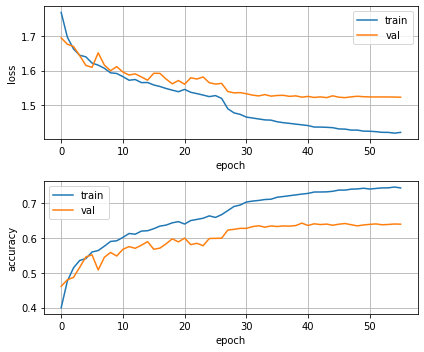

In [16]:
### Loss, Accuracy 시각화

plt.figure(figsize = (6,5))

# Loss
plt.subplot(211)
plt.plot(train_loss,label = "train")
plt.plot(val_loss,label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

# Accuracy
plt.subplot(212)
plt.plot(train_accuracy,label = "train")
plt.plot(val_accuracy,label = "val")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.grid("on")
plt.legend()

plt.tight_layout()

- batch size:64 에 비해 성능이 0.0312 향상됨